In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats.stats import pearsonr 
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
df = pd.read_csv('dataCleanNoOutlier.csv')
# Drop the Week column, same info is captured in weekno
df = df.drop('Week', 1)
df.head()

,revenue,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,...,logSocialpostlag,organicnew2,logOrganicnew,blognewusers2,blognewusersRecip,Fbpostimplag2,weekOfYear2,sinWeekOfYear,Twpostimp2,logTwpostimp
0,178480,1,1,0,987718,983958.0000,31589,4715,105901,1519,...,198063.75,574369156,10.084391,3717184,0.000519,23343103440,25,0.822984,2245432996,10.766082
1,185390,2,1,0,660136,907388.9167,30428,4540,108652,1589,...,196355.00,600740100,10.106836,4137156,0.000492,21755266688,36,0.748511,8690900625,11.442771
2,178130,3,1,0,604606,852862.4167,30715,4417,119398,1595,...,194301.80,664144441,10.157005,10569001,0.000308,22414206939,49,0.663123,42966656656,12.241845
3,185020,4,1,0,560656,851885.3333,31632,4372,134819,1606,...,196355.00,679540624,10.168464,37601424,0.000163,21358244109,64,0.568065,4117917241,11.069307
4,170950,5,1,0,326112,827164.4167,NaN,4431,115865,1522,...,216089.00,581533225,10.090589,3069504,0.000571,NaN,81,0.464723,2996248644,10.910313


In [3]:
def rescale(x):
    '''
    Rescale a vector x such that all values lie on the interval [0, 1]
    x: an np.array
    '''
    x = x - np.min(x)
    x = x / np.max(x)
    return x

# Test
x = np.array([4, 3, 9, 1, 7, 11])
rescale(x)

array([ 0.3,  0.2,  0.8,  0. ,  0.6,  1. ])

In [4]:
# Rescale all columns
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

In [5]:
# Transform each of the following by their optimal exponential transform
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['Fbpostimp'] = df['Fbpostimp'] ** 0.33
df['Fbpostimplag'] = df['Fbpostimplag'] ** 0.29
df['Fblikes'] = df['Fblikes'] ** 0.60
df['Fbengage'] = df['Fbengage'] ** 0.44
df['Twpostimp'] = df['Twpostimp'] ** 0.29

In [6]:
# Rescale all columns again
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

In [7]:
df.fillna(method = 'ffill', axis = 0, inplace = True)
df.fillna(method = 'bfill', axis = 0, inplace = True)

In [8]:
def sse(mod, X, y):
    predictions = mod.predict(X)
    sq_error = [
        (pred - actual) ** 2 for (pred, actual) in zip(predictions, y)]
    RSS = sum(sq_error)
    
    return(RSS)

In [9]:
currentBest = {'model': 'ridge_clf', 'sse': 4972919587.0328007}

# Further Exploration of Interaction Terms
Although there has been some limited exploration of interaction terms, none of the best models have made use of these terms.  Given that a number of the predictors appear to have periodic that coincide, it seems reasonable that there may be important interactions that have been missed.  To explore this in a more systematic way, compare correlations between pairs of predictors and the response. For example:

In [10]:
interactions = []
interaction_corrs = []

for i in range(1, 46):
    for j in range(i + 1, 47):
        interaction = df.ix[:, i] * df.ix[:, j]
        correlation = abs(pearsonr(df.ix[:, 0], interaction)[0])
        interactions.append('{}:{}'.format(
                df.columns.values[i], df.columns.values[j]))
        interaction_corrs.append(correlation)

In [11]:
cordf = pd.DataFrame(interactions, columns = ['interactions'])
cordf['abs_correlations'] = interaction_corrs
cordf.sort_values(by = 'abs_correlations', ascending = False, inplace = True)
cordf.index = range(cordf.shape[0])
cordf.head(10)

,interactions,abs_correlations
0,organicnew:rev1weekAgo,0.692465
1,organicnew:rev3weekAgo,0.661738
2,brandpaid:organicnew,0.654123
3,organicnew:rev2weekAgo,0.646716
4,organicnew:rev4weekAgo,0.641619
5,organicnew:Fbpostimplag,0.627440
6,brandpaid:rev1weekAgo,0.598747
7,highseason:organicnew,0.595880
8,organicnew:youtube,0.577173
9,organicnew:youtubelag,0.574794


Add interaction columns to df

In [12]:
for i in range(10):
    cols = cordf['interactions'][i]
    orig_cols = cols.split(':')
    df[cols] = df[orig_cols[0]] * df[orig_cols[1]]
    
df.head()

,revenue,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,...,organicnew:rev1weekAgo,organicnew:rev3weekAgo,brandpaid:organicnew,organicnew:rev2weekAgo,organicnew:rev4weekAgo,organicnew:Fbpostimplag,brandpaid:rev1weekAgo,highseason:organicnew,organicnew:youtube,organicnew:youtubelag
0,178480,1,1,0,0.064597,0.073350,0.491038,0.087455,0.134651,0.131320,...,0.639412,0.639412,0.397723,0.639412,0.639412,0.568964,0.387642,0.809963,0.300182,0.294394
1,185390,2,1,0,0.035944,0.062603,0.470952,0.042835,0.146745,0.155073,...,0.678238,0.678238,0.404616,0.678238,0.678238,0.596404,0.371785,0.859145,0.409169,0.354803
2,178130,3,1,0,0.031087,0.054949,0.475917,0.011474,0.193984,0.157109,...,0.818698,0.768237,0.463138,0.768237,0.768237,0.678948,0.400383,0.973149,0.358641,0.446959
3,185020,4,1,0,0.027243,0.054812,0.491782,0.000000,0.261776,0.160842,...,0.786808,0.789434,0.491782,0.841288,0.789434,0.692028,0.386938,1.000000,0.211041,0.427889
4,170950,5,1,0,0.006728,0.051342,0.491782,0.015043,0.178453,0.132338,...,0.690458,0.692745,0.404950,0.647884,0.650047,0.569839,0.412365,0.823434,0.173632,0.299396


In [13]:
# Don't forget to recreate test/train sets!
# Separate df into X (predictors) and y (response)
df.shape

(117, 67)

In [14]:
X = df.ix[:, 1:68]
y = df.ix[:, 0]

# Now split each into testing and training sets
# Ideally, we would stratify the data, but there are too few data in this
# sample 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 11)

In [15]:
X_train.head()

,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,organicnew,...,organicnew:rev1weekAgo,organicnew:rev3weekAgo,brandpaid:organicnew,organicnew:rev2weekAgo,organicnew:rev4weekAgo,organicnew:Fbpostimplag,brandpaid:rev1weekAgo,highseason:organicnew,organicnew:youtube,organicnew:youtubelag
110,111,1,0,0.504781,0.965312,0.442370,0.614227,0.370969,0.487954,0.518850,...,0.282514,0.301164,0.229524,0.331221,0.311793,0.305120,0.240870,0.518850,0.446364,0.472873
28,29,0,0,0.060270,0.060954,0.481003,0.601989,0.171516,0.268069,0.594431,...,0.338878,0.366802,0.285923,0.275001,0.301230,0.361566,0.274215,0.000000,0.103296,0.038972
51,52,1,0,0.402618,0.373283,0.595848,0.993881,0.534335,0.441127,0.834825,...,0.518148,0.580293,0.497429,0.535501,0.096977,0.781028,0.369823,0.834825,0.518300,0.435800
56,57,1,0,0.420757,0.605760,0.645554,0.648649,0.387652,0.377672,0.917639,...,0.707407,0.809252,0.592385,0.788525,0.718906,0.757653,0.497657,0.917639,0.608404,0.693622
39,40,1,0,0.201701,0.142477,0.703339,0.789648,0.341876,0.415677,0.707983,...,0.322859,0.372799,0.497952,0.305114,0.503015,0.632490,0.320741,0.707983,0.323618,0.341021


In [16]:
pipe_lasso = Pipeline([(
            'clf', Lasso(random_state = 11, max_iter = 1000000))])
alpha_range = np.linspace(1, 100, 30)
train_scores, test_scores = validation_curve(estimator = pipe_lasso,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

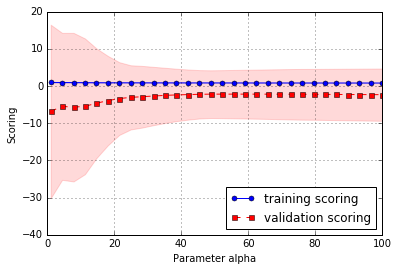

In [17]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training scoring');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation scoring');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
#plt.xscale('log');
plt.legend(loc = 'lower right');
plt.xlabel('Parameter alpha');
plt.ylabel('Scoring');
#plt.ylim([-2.5, -2]); # zoom to see alpha peak at ~ 50
plt.show();

In [18]:
lasso_clf2 = Lasso(alpha = 50, random_state = 11, max_iter = 1000000) 
lasso_clf2.fit(X_train, y_train)
sse(lasso_clf2, X_test, y_test)

6080841400.2420006

In [19]:
currentBest

{'model': 'ridge_clf', 'sse': 4972919587.032801}

In [20]:
# Uncommment to view, if interested
#zip(df.columns.values, lasso_clf2.coef_)
# As before: the first predictor is the intercept term, NOT 'revenue'

In [21]:
#X_train.shape
#X_train.ix[1, 0:63]

In [22]:
pipe_ridge = Pipeline([('clf', Ridge(random_state = 11))])

alpha_range = np.linspace(0, 30, num = 30)
# ipython gets hung up if you attempt to use the entire X_train data, so 
# a few cols are omitted here
train_scores, test_scores = validation_curve(estimator = pipe_ridge,
                                             X = X_train.ix[:, 0:63],
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)

In [23]:
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

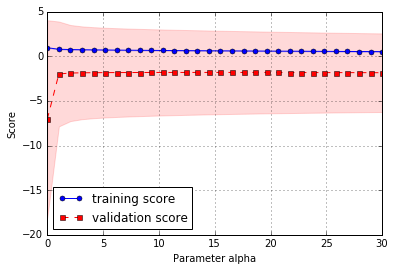

In [24]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training score');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation score');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
plt.legend(loc = 'lower left');
#plt.xscale('log');
plt.xlabel('Parameter alpha');
plt.ylabel('Score');
#plt.ylim([-2, -1.5]); # uncomment to zoom in to see peak alpha ~ 15 better
plt.show();

In [25]:
ridge_clf2 = Ridge(alpha = 15, random_state = 11) # 2.x, 4.5
ridge_clf2.fit(X_train, y_train)
sse(ridge_clf2, X_test, y_test)

4944749755.1920271

In [26]:
currentBest

{'model': 'ridge_clf', 'sse': 4972919587.032801}

In [27]:
# A slight improvement.  Update:
currentBest = { 'model': 'ridge_clf2', 
                'sse': sse(ridge_clf2, X_test, y_test)}

In [28]:
avg_error = np.sqrt(currentBest['sse'] / len(y_test))
print 'Avg. error: $%.2f' % avg_error
print 'Std Dev. of revenue: $%.2f'%np.std(df['revenue'])

Avg. error: $12838.42
Std Dev. of revenue: $23841.97


Just to get a visual sense of how well the current best model is performing, plot the revenue with it's mean and the interval of ± 1sd and ± avg. model error

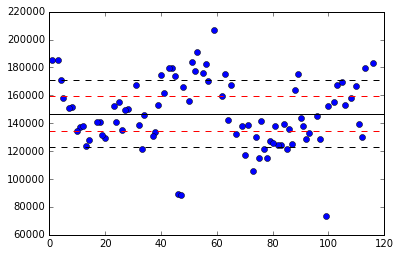

In [29]:
plt.plot(y_train, 'bo');
m = np.mean(y_train)
s = np.std(y_train)
plt.plot((0, 120), (m, m), 'k-');
plt.plot((0, 120), (m + s, m + s), 'k--');
plt.plot((0, 120), (m - s, m - s), 'k--');
plt.plot((0, 120), (m + avg_error, m + avg_error), 'r--');
plt.plot((0, 120), (m - avg_error, m - avg_error), 'r--');

# Final Model

The best model found, `ridge_clf2`,  was the ridge regression model on the dataset with obvious outliers removed and with long-tailed predictors transformed to normalize. The final step in making this model more robust will be to apply it to the entire data set (i.e., merging the training and test sets back together) to make it more robust.

In [30]:
ridge_clf_FINAL = Ridge(alpha = 15, random_state = 11)
ridge_clf_FINAL.fit(X, y)

Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=11, solver='auto', tol=0.001)

# Test New Data
This section was added to simplify the process of testing new data
This file assumes that revenue has been moved to column 1, and that all blanks have been replaced with 'NA' values.

In [31]:
# CHANGE: Path to directory of the .csv file to be tested
datapath = 'data.csv'

In [32]:
test_df = pd.read_csv(datapath)
test_df.head()

,revenue,Week,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,...,emailclick,blogvisits,blognewusers,blogrefer,blogrefernew,blogsignup,autoenroll,socialperson,promoteposts,learner
0,178480,2/2/14,1,1,0,987718,983958.0000,31589,4715,105901,...,2969,2802,1928,303,124,18,1,1,0,0
1,185390,2/9/14,2,1,0,660136,907388.9167,30428,4540,108652,...,3278,2940,2034,277,106,16,1,1,0,0
2,178130,2/16/14,3,1,0,604606,852862.4167,30715,4417,119398,...,2907,4359,3251,412,225,21,1,1,0,0
3,185020,2/23/14,4,1,0,560656,851885.3333,31632,4372,134819,...,3557,7408,6132,970,553,19,1,1,0,0
4,170950,3/2/14,5,1,0,326112,827164.4167,NaN,4431,115865,...,2455,2616,1752,310,111,11,1,1,0,0


In [33]:
nrows = test_df.shape[0]

In [34]:
rev = df['revenue']
rev1weekAgo = [np.nan]
rev2weekAgo = [np.nan] * 2
rev3weekAgo = [np.nan] * 3
rev4weekAgo = [np.nan] * 4

for r in rev[0:(nrows - 1)]:
    rev1weekAgo.append(r)
for r in rev[0:(nrows - 2)]:
    rev2weekAgo.append(r)
for r in rev[0:(nrows - 3)]:
    rev3weekAgo.append(r)
for r in rev[0:(nrows - 4)]:
    rev4weekAgo.append(r)

test_df['rev1weekAgo'] = rev1weekAgo
test_df['rev2weekAgo'] = rev2weekAgo
test_df['rev3weekAgo'] = rev3weekAgo
test_df['rev4weekAgo'] = rev4weekAgo

We cannot assume that new data will necessarily be temporally ordered, or in sequential order, but we can still use the `Week` data to determine the weekOfYear.

In [35]:
type(test_df['Week'][0])

str

In [36]:
# To convert a date string to calendar week
print datetime.strptime('2/2/14', '%m/%d/%y').isocalendar()[1]
print datetime.strptime('12/27/14', '%m/%d/%y').isocalendar()[1]

5
52


In [37]:
test_df['weekOfYear']        = test_df['Week'].apply(
    lambda date: datetime.strptime(date, '%m/%d/%y').isocalendar()[1])
test_df['fbEngage3']         = test_df['Fbengage'] ** 3
# Just realized this datum never actually got transformed... 
test_df['logSocialpostlag']  = (test_df['socialpostlag'])
test_df['organicnew2']       = test_df['organicnew'] ** 2
test_df['logOrganicnew']     = np.log(test_df['organicnew'])
test_df['blognewusers2']     = test_df['blognewusers'] ** 2
test_df['blognewusersRecip'] = 1 / test_df['blognewusers']
test_df['Fbpostimplag2']     = test_df['Fbpostimplag'] ** 2
test_df['weekOfYear2']       = test_df['weekOfYear'] ** 2
test_df['sinWeekOfYear']     = np.sin(np.pi * (test_df['weekOfYear'] + 13) / 26)
test_df['Twpostimp2']        = test_df['Twpostimp'] ** 2
test_df['logTwpostimp']      = np.log(test_df['Twpostimp'])
test_df.drop('Week', 1)

,revenue,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,...,logSocialpostlag,organicnew2,logOrganicnew,blognewusers2,blognewusersRecip,Fbpostimplag2,weekOfYear2,sinWeekOfYear,Twpostimp2,logTwpostimp
0,178480,1,1,0,987718,9.839580e+05,31589,4715,105901,1519,...,198063.75000,574369156,10.084391,3717184,0.000519,2.334310e+10,25,8.229839e-01,2245432996,10.766082
1,185390,2,1,0,660136,9.073889e+05,30428,4540,108652,1589,...,196355.00000,600740100,10.106836,4137156,0.000492,2.175527e+10,36,7.485107e-01,8690900625,11.442771
2,178130,3,1,0,604606,8.528624e+05,30715,4417,119398,1595,...,194301.80000,664144441,10.157005,10569001,0.000308,2.241421e+10,49,6.631227e-01,42966656656,12.241845
3,185020,4,1,0,560656,8.518853e+05,31632,4372,134819,1606,...,196355.00000,679540624,10.168464,37601424,0.000163,2.135824e+10,64,5.680647e-01,4117917241,11.069307
4,170950,5,1,0,326112,8.271644e+05,NaN,4431,115865,1522,...,216089.00000,581533225,10.090589,3069504,0.000571,NaN,81,4.647232e-01,2996248644,10.910313
5,158310,6,1,0,261269,8.006612e+05,28387,5052,118742,1673,...,210775.50000,509991889,10.024953,7160976,0.000374,1.925465e+10,100,3.546049e-01,3037332544,10.917123
6,149580,7,1,0,395374,7.678632e+05,28092,5641,112045,NaN,...,201430.10000,479829025,9.994470,2979076,0.000579,1.824992e+10,121,2.393157e-01,NaN,NaN
7,150630,8,1,0,249191,7.038648e+05,28925,5594,107740,1651,...,200053.54550,508547601,10.023535,NaN,NaN,1.743885e+10,144,1.205367e-01,1721254144,10.633160
8,151660,9,0,0,283502,6.327742e+05,27720,5076,94545,1450,...,197325.41670,495596644,10.010636,4100625,0.000494,1.687362e+10,169,-3.216245e-16,1327654969,10.503340
9,139820,10,0,0,562285,6.176458e+05,27133,5040,87266,1219,...,194889.33330,454585041,9.967448,5202961,0.000438,1.646014e+10,196,-1.205367e-01,1548973449,10.580429


In [38]:
# Rescale all columns
test_df.ix[:, 2:59] = test_df.ix[:, 2:59].apply(rescale) 

# Transform each of the following by their optimal exponential transform
test_df['socialpostimp'] = test_df['socialpostimp'] ** 0.29
test_df['socialpostimp'] = test_df['socialpostimp'] ** 0.29
test_df['Fbpostimp']     = test_df['Fbpostimp'] ** 0.33
test_df['Fbpostimplag']  = test_df['Fbpostimplag'] ** 0.29
test_df['Fblikes']       = test_df['Fblikes'] ** 0.60
test_df['Fbengage']      = test_df['Fbengage'] ** 0.44
test_df['Twpostimp']     = test_df['Twpostimp'] ** 0.29

# Rescale all columns again
test_df.ix[:, 2:59] = test_df.ix[:, 2:59].apply(rescale) 

In [39]:
# Do NOT fill NAs unless the data are in fact sequential weeks.  Verify:
all_weeks_sequential = True # Change to False if need be
if all_weeks_sequential:
    test_df.fillna(method = 'ffill', axis = 0, inplace = True)
    test_df.fillna(method = 'bfill', axis = 0, inplace = True)

In [40]:
# Add interaction columns
for i in range(10):
    cols = cordf['interactions'][i]
    orig_cols = cols.split(':')
    test_df[cols] = test_df[orig_cols[0]] * test_df[orig_cols[1]]
    
test_df.head()

,revenue,Week,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,...,organicnew:rev1weekAgo,organicnew:rev3weekAgo,brandpaid:organicnew,organicnew:rev2weekAgo,organicnew:rev4weekAgo,organicnew:Fbpostimplag,brandpaid:rev1weekAgo,highseason:organicnew,organicnew:youtube,organicnew:youtubelag
0,178480,2/2/14,0.000000,1,0,0.001349,0.001020,0.095505,0.087455,0.134651,...,0.639412,0.639412,0.077356,0.639412,0.639412,0.568964,0.075395,0.809963,0.300182,0.294394
1,185390,2/9/14,0.008621,1,0,0.000750,0.000870,0.091599,0.042835,0.146745,...,0.678238,0.678238,0.078696,0.678238,0.678238,0.596404,0.072311,0.859145,0.409169,0.354803
2,178130,2/16/14,0.017241,1,0,0.000649,0.000764,0.092564,0.011474,0.193984,...,0.818698,0.768237,0.090079,0.768237,0.768237,0.678948,0.077873,0.973149,0.358641,0.446959
3,185020,2/23/14,0.025862,1,0,0.000569,0.000762,0.095650,0.000000,0.261776,...,0.786808,0.789434,0.095650,0.841288,0.789434,0.692028,0.075258,1.000000,0.211041,0.427889
4,170950,3/2/14,0.034483,1,0,0.000140,0.000714,0.095650,0.015043,0.178453,...,0.690458,0.692745,0.078761,0.647884,0.650047,0.569839,0.080204,0.823434,0.173632,0.299396


In [41]:
test_data_X = df.ix[:, 1:68]
test_data_y = df.ix[:, 0]

In [42]:
# Make predictions:
ridge_clf_FINAL.predict(test_data_X)

array([ 168509.67868987,  169677.68061556,  170581.38987294,
        171516.53225095,  167682.35280446,  159647.73037364,
        157431.49661313,  158243.27841277,  148861.85370914,
        145068.86141985,  140672.78753856,  140617.63003211,
        139517.08834767,  139643.73031664,  135854.83210445,
        137801.70018181,  134642.66573752,  137333.34432819,
        136041.89210985,  133906.63932631,  135847.03387305,
        132076.15458902,  134709.04409938,  139419.4151704 ,
        141694.55802065,  140304.0712929 ,  142537.97780828,
        139631.70080097,  140149.42566534,  143320.38896355,
        145621.87625537,  148988.82298524,  150828.50252271,
        148737.97453641,  143750.26969311,  151338.21584033,
        153418.11066644,  149833.83716047,  150162.35227936,
        156095.5036843 ,  155368.47496934,  157522.70649584,
        138828.18721985,  150008.74606168,  156470.20162926,
        147929.84477134,  118963.34505438,  122804.85057847,
        160283.38513264,

In [43]:
# Check SSE
test_data_sse = sse(ridge_clf_FINAL, test_data_X, test_data_y)
test_data_sse

22811525991.891602

In [44]:
# Get average prediction error
print 'Average error: $%.2f' %(np.sqrt(test_data_sse / nrows))

Average error: $13963.18


# Final Thoughts
I am currently in the process of learning more about cointigrated time series and Bayesian methods for TS data, but am regrettably not very familiar with them at this point, so stuck with what I do know for this assignment, but would be very excited to try these new skills out at some point soon!

Thank you for taking the time to look at my work!